<a href="https://colab.research.google.com/github/DiMorten/FCN_ConvLSTM_Crop_Recognition_Open_Set/blob/coords5/train_and_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies

In [1]:
!pip install icecream
#%tensorflow_version 1.x
import os
!pip install kora
from kora import drive
import time
!pip install colorama

ds_path='/content/drive/My Drive/PhD/datasets/cv_data/'

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
git_clone = True

if git_clone == True:
  os.chdir('/content')
  %rm -rf FCN_ConvLSTM_Crop_Recognition_Open_Set
  !git clone --branch coords5 https://github.com/DiMorten/FCN_ConvLSTM_Crop_Recognition_Open_Set.git

Cloning into 'FCN_ConvLSTM_Crop_Recognition_Open_Set'...
remote: Enumerating objects: 2186, done.
remote: Counting objects: 100% (2186/2186), done.
remote: Compressing objects: 100% (1615/1615), done.
remote: Total 2186 (delta 1438), reused 1063 (delta 366), pack-reused 0
Receiving objects: 100% (2186/2186), 37.49 MiB | 25.21 MiB/s, done.
Resolving deltas: 100% (1438/1438), done.


## Download images into proper folder

In [4]:
!cp -r /content/drive/MyDrive/PhD/datasets/cv_data /content/FCN_ConvLSTM_Crop_Recognition_Open_Set/dataset/dataset/

In [5]:
os.chdir('/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src')
os.getcwd()
os.listdir()

['mosaic.py.old',
 'postprocessing.py',
 'model_input_mode.py',
 'model_best_UUnet4ConvLSTM_jun_cv_criteria_0_92',
 'densnet_timedistributed.py',
 '__init__.py',
 'keras_weighted_categorical_crossentropy.py',
 'deb.py',
 'model.py',
 'modelArchitecture.py',
 'main.py',
 'patch_extractor.py',
 'parameters',
 'mosaic.py',
 'metrics.py',
 'monitor.py',
 'dataset.py',
 'generator.py',
 'open_set.py',
 'obj',
 'dataSource.py',
 'densnet.py',
 'analysis']

In [6]:
from colorama import init
init()
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Conv2DTranspose
# from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
from tensorflow.keras.optimizers import Adam,Adagrad 
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow.keras as keras

import numpy as np
from sklearn.utils import shuffle
import cv2
import argparse
import tensorflow as tf

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import metrics
import sys
import glob

from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,classification_report
# Local
from densnet import DenseNetFCN
from densnet_timedistributed import DenseNetFCNTimeDistributed

#from metrics import fmeasure,categorical_accuracy
import deb
from keras_weighted_categorical_crossentropy import weighted_categorical_crossentropy, sparse_accuracy_ignoring_last_label, weighted_categorical_crossentropy_ignoring_last_label, categorical_focal_ignoring_last_label, weighted_categorical_focal_ignoring_last_label
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import ConvLSTM2D, UpSampling2D, multiply
from tensorflow.keras.regularizers import l1,l2
import time
import pickle
#from tensorflow.keras_self_attention import SeqSelfAttention
import pdb
import pathlib
from pathlib import Path, PureWindowsPath
from tensorflow.keras.layers import Conv3DTranspose, Conv3D

from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from collections import Counter


#from datagenerator import DataGenerator
from generator import DataGenerator, DataGeneratorWithCoords, DataGeneratorWithCoordsRandom

import matplotlib.pyplot as plt
sys.path.append('../../../dataset/dataset/patches_extract_script/')
from dataSource import DataSource, SARSource, OpticalSource, Dataset, LEM, LEM2, CampoVerde, OpticalSourceWithClouds, Humidity
from model_input_mode import MIMFixed, MIMVarLabel, MIMVarSeqLabel, MIMVarLabel_PaddedSeq, MIMFixedLabelAllLabels, MIMFixed_PaddedSeq
from parameters.parameters_reader import ParamsTrain

from icecream import ic
from monitor import Monitor, MonitorNPY, MonitorGenerator, MonitorNPYAndGenerator
import natsort
from model import NetModel, ModelFit, ModelLoadGeneratorWithCoords
from dataset import Dataset, DatasetWithCoords

from patch_extractor import PatchExtractor
ic.configureOutput(includeContext=False)
np.random.seed(2021)
tf.random.set_seed(2021)

from main import TrainTest

In [7]:
!nvidia-smi

Sat Aug 21 17:17:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set parameters

Parameters can be modified in /content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src/parameters/parameters_reader.py

In [8]:
from pathlib import Path

paramsTrain = ParamsTrain('parameters/')
paramsTrain.mim = MIMFixed_PaddedSeq()

paramsTrain.getFullIms = True
paramsTrain.coordsExtract = True
paramsTrain.train = True

paramsTrain.train_overlap_percentage = 0
paramsTrain.trainGeneratorRandom = False
paramsTrain.patch_len = 32
paramsTrain.stride = int(paramsTrain.patch_len - paramsTrain.patch_len * paramsTrain.train_overlap_percentage)
paramsTrain.patch_step_train = paramsTrain.stride
paramsTrain.patch_step_test = paramsTrain.patch_len # to do: paramsTrain.getCalculatedParams() does these calculations

paramsTrain.dataset = 'cv'
paramsTrain.seq_date = 'jun'
paramsTrain.path = Path("../../../dataset/dataset/") / (paramsTrain.dataset + "_data")

paramsTrain.test_overlap_percentage = 0

paramsTrain.dataSource = SARSource()
paramsTrain.openSetMethod = None
trainTest = TrainTest(paramsTrain)

patchExtractor = PatchExtractor(paramsTrain, trainTest.ds)	

[@debug] parameters_reader.py:115 in __init__()- self.seq_date: 'mar'


self.known_classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


[@debug] parameters_reader.py:174 in __init__()- self.stride: 32


['parameters_reader.py', 'save_nonaugmented_train_patches_unknownclasses.json', 'save_nonaugmented_train_patches.json', 'cv', 'twokkc_parameters_closedset_groupclasses.json', 'twokkc_parameters_openset.json', '__pycache__', 'twokkc_save_nonaugmented_train_patches.json', 'save_nonaugmented_train_patches_lessclass8.json', 'allkkc_save_nonaugmented_train_patches.json', 'params_batchprocessing.py', 'parameters_openset_lessclass8.json', '__init__.py', 'params_reconstruct.py', 'no_mode.json', 'allkkc_parameters_openset.json', 'parameters_openset.json', 'parameters_closedset_groupclasses.json', 'parameters_openset_specifyunknownclasses.json', 'parameters_closedset_groupclasses_lessclass8.json']
[@debug] self.seq_mode = fixed
[@debug] self.mim = <model_input_mode.MIMFixed_PaddedSeq object at 0x7f8d95c025d0>
[@debug] self.ds = <dataSource.CampoVerde object at 0x7f8d95c025d0>
20151029
20151110
20151122
20151204
20151216
20160121
20160214
20160309
20160321
20160508
20160520
20160613
dotys_sin_cos

[@debug] patch_extractor.py:17 in __init__()
         self.dataSource: <dataSource.SARSource object at 0x7f8d95c02290>
[@debug] patch_extractor.py:26 in __init__()
         self.conf['path']/self.label_folder/"/": PosixPath('/')
[@debug] patch_extractor.py:35 in __init__()
         self.conf["in_npy_path"]: PosixPath('../../../dataset/dataset/cv_data/in_sar')
[@debug] patch_extractor.py:43 in __init__()
         self.conf["train"]["mask"]["dir"]: PosixPath('../../../dataset/dataset/cv_data/TrainTestMask.tif')
[@debug] patch_extractor.py:44 in __init__()
         os.getcwd(): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'


## Download or load sequence of images


In [9]:
if paramsTrain.getFullIms == True:
  patchExtractor.getFullIms()	
else:
  patchExtractor.fullImsLoad()


[@debug] patch_extractor.py:90 in getFullIms()
         patch["full_ims"].shape: (12, 8492, 7995, 2)
[@debug] patch_extractor.py:91 in getFullIms()
         self.dataset.im_list: ['20151029_S1',
                                '20151110_S1',
                                '20151122_S1',
                                '20151204_S1',
                                '20151216_S1',
                                '20160121_S1',
                                '20160214_S1',
                                '20160309_S1',
                                '20160321_S1',
                                '20160508_S1',
                                '20160520_S1',
                                '20160613_S1']


0 0
[@debug] conf["in_npy_path"]/(im_names[t_step]+".npy") = ../../../dataset/dataset/cv_data/in_sar/20151029_S1.npy
[@debug] patch["full_ims"].dtype = float16
[@debug] np.average(patch["full_ims"][t_step]) = 0.1871337890625
[@debug] np.max(patch["full_ims"][t_step]) = 1.0
[@debug] np.min(patch["full_ims"][t_step]) = 4.172325134277344e-07
../../../dataset/dataset/cv_data/labels/20151029_S1.tif
[@debug] conf["path"]/(self.dataSource.label_folder+"/"+label_names[t_step]+".tif") = ../../../dataset/dataset/cv_data/labels/20151029_S1.tif
[@debug] np.unique(patch["full_label_ims"][t_step],return_counts=True) = (array([ 0,  1,  2,  6,  7,  8,  9, 10, 11], dtype=int8), array([61778564,    45178,    51808,   131138,   438371,   155189,
        5136068,     1007,   156217]))
1 0
[@debug] conf["in_npy_path"]/(im_names[t_step]+".npy") = ../../../dataset/dataset/cv_data/in_sar/20151110_S1.npy
[@debug] patch["full_ims"].dtype = float16
[@debug] np.average(patch["full_ims"][t_step]) = 0.180419921875


[@debug] dataSource.py:369 in im_load()
         patch["full_ims"].shape: (12, 8492, 7995, 2)
[@debug] dataSource.py:370 in im_load()
         patch["full_label_ims"].shape: (12, 8492, 7995)
[@debug] dataSource.py:371 in im_load()
         patch["full_ims"].dtype: dtype('float16')
[@debug] dataSource.py:372 in im_load()
         patch["full_label_ims"].dtype: dtype('int8')


[@debug] np.unique(patch['full_label_ims'],return_counts=True) = (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int8), array([741342768,  17247080,   7809932,  12457060,    185790,     51702,
         2462898,   5372125,   1862268,  24044169,     12084,   1874604]))
0.0 1.0 0.1702
[@debug] self.dataset.name = cv
[@debug] self.dataset.scaler_name = cv
[@debug] self.dataset.seq_mode = fixed
[@debug] self.dataset.seq_date = jun
[@debug] self.dataset.scaler_load = False
[@debug] im.shape = (12, 8492, 7995, 2)
[@debug] im_flat[mask_flat==1,:].shape = (38664648, 2)
0.0001407 1.0 0.0779
[@debug] im_norm.shape = (12, 8492, 7995, 2)
FINISHED NORMALIZING, RESULT:
-1.432 51.53 3.117
[@debug] im.shape = (12, 8492, 7995)
[@debug] mask_train.shape = (8492, 7995)
[@debug] im.dtype = uint8
[@debug] mask_train.dtype = uint8
[@debug] im_train.shape = (12, 8492, 7995)
Train masked unique/count [ 0  1  2  3  4  5  6  7  8  9 10 11] [776057832   9399025   4170646   6930141    103494     346

[@debug] patch_extractor.py:127 in getFullIms()
         self.paramsTrain.path / 'full_ims/full_ims_test.npy': PosixPath('../../../dataset/dataset/cv_data/full_ims/full_ims_test.npy')


## Extract coords of image patches

In [10]:

if paramsTrain.coordsExtract == True:
  patchExtractor.extract()

del patchExtractor



STARTED PATCH EXTRACTION
[@debug] gridx.shape = (250,)
[@debug] gridy.shape = (266,)


[@debug] patch_extractor.py:205 in extract()
         coords_train.shape: (4983, 2)
         coords_test.shape: (4626, 2)
[@debug] patch_extractor.py:206 in extract()
         coords_train.dtype: dtype('int64')
[@debug] patch_extractor.py:207 in extract()
         coords_train[0]: array([7568,  656])


## Train


Initializing object...
12 2
[@debug] self.channel_n = 2


[@debug] dataset.py:96 in __init__()- self.class_n: 10


[@debug] self.t_len = 12
Initializing Dataset instance


[@debug] main.py:118 in setData()- self.data.class_n: 10
[@debug] main.py:146 in preprocess()
         self.model_name: '../results/convlstm_results/model/lm/model_best_UUnetConvLSTM_mar_lm_nomode.h5'
[@debug] dataset.py:186 in create_load()
         os.path.dirname(os.path.abspath(__file__)): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'
[@debug] dataset.py:187 in create_load()
         os.getcwd(): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'
[@debug] dataset.py:191 in create_load()
         self.patches['train']['coords'].shape: (4983, 2)
[@debug] dataset.py:284 in labelPreprocess()
         np.unique(self.full_label_train, return_counts=True): (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8),
                                                                array([64671486,   710232,  1374508,    31550,   136800,   212701,
                                                                   

[@debug] np.unique(self.full_label_train, return_counts=True) = (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8), array([64671486,   710232,  1374508,    31550,   136800,   212701,
          71804,   617076,      699,    66684]))


[@debug] dataset.py:343 in labelPreprocess()
         self.labels2new_labels: {0: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8, 11: 9}
         self.new_labels2labels: {0: 0, 1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11}


Transforming labels2new_labels...
Transformed labels2new_labels. Moving bcknd to last...
[@debug] dict_filename = results/label_translations/new_labels2labels_cv_20160613_S1.pkl
[@debug] self.new_labels2labels = {0: 0, 1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11}


[@debug] dataset.py:364 in labelPreprocess()
         np.unique(self.full_label_train, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                                array([64671486,   710232,  1374508,    31550,   136800,   212701,
                                                                         71804,   617076,      699,    66684]))


Moved bcknd to last


[@debug] dataset.py:373 in labelPreprocess()
         np.unique(self.full_label_train, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                                array([  710232,  1374508,    31550,   136800,   212701,    71804,
                                                                        617076,      699,    66684, 64671486]))
[@debug] dataset.py:374 in labelPreprocess()
         np.unique(self.full_label_test, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                               array([  730790,  1199149,    25986,    88785,   312353,    83385,
                                                                       362633,      308,    89533, 65000618]))
[@debug] dataset.py:377 in labelPreprocess()- self.class_n: 10
[@debug] dataset.py:215 in create_load()
         self.patches['train']['label'].shape: (4983, 32, 32)
[@debug] dataset.py:216 in cr

=== SELECT VALIDATION SET FROM TRAIN SET


[@debug] main.py:159 in preprocess()- self.paramsTrain.val_set: True


[@debug] self.paramsTrain.val_set_mode = random


[@debug] dataset.py:402 in val_set_get()
         self.patches['train']['n']: 4983
         self.patches['val']['n']: 747
[@debug] dataset.py:403 in val_set_get()
         self.patches['train']['coords'].shape: (4983, 2)
[@debug] dataset.py:412 in val_set_get()
         self.patches['train']['coords'].shape: (4236, 2)
[@debug] dataset.py:413 in val_set_get()
         self.patches['val']['coords'].shape: (747, 2)
[@debug] main.py:163 in preprocess()
         self.data.patches['val']['coords'].shape: (747, 2)


=== AUGMENTING TRAINING DATA
[@debug] label_type = Nto1
Before balancing:
data.semantic_balance


[@debug] dataset.py:439 in semantic_balance()
         balance["coords"].shape: (6300, 2)
[@debug] dataset.py:443 in semantic_balance()
         np.unique(self.full_label_train, return_counts = True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                                  array([  710232,  1374508,    31550,   136800,   212701,    71804,
                                                                          617076,      699,    66684, 64671486]))
[@debug] dataset.py:449 in semantic_balance()
         coords_classes.shape: (4236, 10)
[@debug] dataset.py:451 in semantic_balance()
         unique_train: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)
[@debug] dataset.py:453 in semantic_balance()- bcknd_idx: 9
[@debug] dataset.py:455 in semantic_balance()- psize: 32
[@debug] dataset.py:468 in semantic_balance()
         patch_count: array([1055., 1820.,   55.,  196.,  352.,  125.,  882.,    6.,  120.,
                                0.])

[@debug] clss = 0


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 1820.0
[@debug] dataset.py:478 in semantic_balance()- clss: 1
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([2416, 1820]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (1820, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 1


[@debug] dataset.py:474 in semantic_balance()- patch_count[clss]: 55.0
[@debug] dataset.py:478 in semantic_balance()- clss: 2
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4181,   55]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (55, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 2


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 196.0
[@debug] dataset.py:478 in semantic_balance()- clss: 3
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4040,  196]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (196, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 3


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 352.0
[@debug] dataset.py:478 in semantic_balance()- clss: 4
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([3884,  352]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (352, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 4


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 125.0
[@debug] dataset.py:478 in semantic_balance()- clss: 5
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4111,  125]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (125, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 5


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 882.0
[@debug] dataset.py:478 in semantic_balance()- clss: 6
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([3354,  882]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (882, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 6


[@debug] dataset.py:474 in semantic_balance()- patch_count[clss]: 6.0
[@debug] dataset.py:478 in semantic_balance()- clss: 7
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4230,    6]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (6, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 7


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 120.0
[@debug] dataset.py:478 in semantic_balance()- clss: 8
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4116,  120]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (120, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 8
Balanced train unique (coords):
[@debug] self.patches['train']['coords'].shape = (6300, 2)
[@debug] self.data.patches['train']['coords'].shape = (6300, 2)
Initializing object...
12 2
[@debug] self.channel_n = 2
[@debug] self.t_len = 12
Initializing Model instance
[@debug] self.mp = {'dense': {'recurrent_filters': 128, 'nb_dense_block': 2, 'growth_rate': 64, 'nb_layers_per_block': 1}, 'unet': {'recurrent_filters': 128, 'filter_size': 16}, 'atrous': {'recurrent_filters': 128, 'filter_size': 16, 'dilation_rate_mode': 'auto', 'dilation_rates': [1, 2, 4, 8]}}
[@debug] self.stop_epoch = 400


[@debug] main.py:132 in setModel()
         self.model.name: PosixPath('../results/convlstm_results/model/lm/../results/convlstm_results/model/lm/model_best_UUnetConvLSTM_mar_lm_nomode.h5')
[@debug] main.py:134 in setModel()- self.model.class_n: 9
[@debug] main.py:135 in setModel()- self.data.class_n: 10


[@debug] self.data.class_n = 10
[@debug] self.t_len = 12
[@debug] self.model_t_len = 12
Instructions for updating:
Colocations handled automatically by placer.
[@debug] K.int_shape(x) = (None, 12, 8, 8, 64)
[@debug] K.int_shape(res2) = (None, 8, 8, 64)
[@debug] K.int_shape(p3) = (None, 8, 8, 64)
[@debug] K.int_shape(d3) = (None, 8, 8, 64)
[@debug] K.int_shape(x) = (None, 12, 16, 16, 32)
[@debug] K.int_shape(res2) = (None, 16, 16, 32)
[@debug] K.int_shape(p2) = (None, 16, 16, 32)
[@debug] K.int_shape(d2) = (None, 16, 16, 32)
[@debug] K.int_shape(x) = (None, 12, 32, 32, 16)
[@debug] K.int_shape(res2) = (None, 32, 32, 16)
[@debug] K.int_shape(p1) = (None, 32, 32, 16)
[@debug] K.int_shape(d1) = (None, 32, 32, 16)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12, 32, 32,  0              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
[@debug] model.py:243 in train()
         data.patches['train']['coords'].shape: (6300, 2)
[@debug] model.py:248 in train()- data.t_len: 12
[@debug] model.py:249 in train()
         data.full_ims_train.shape: (12, 8492, 7995, 2)
[@debug] model.py:250 in train()- self.model_t_len: 12
[@debug] dataset.py:386 in addPaddingToInput()
         im.shape: (12, 8492, 7995, 2)
[@debug] model.py:256 in train()
         data.full_ims_train.shape: (12, 8492, 7995, 2)
[@debug] model.py:311 in applyFitMethod()- self.class_n: 9
[@debug] model.py:330 in applyFitMethod()
         data.patches['train']['coords'].shape: (6300, 2)
[@debug] model.py:331 in applyFitMethod()
         data.patches['train']['coords'][0:16]: array([[5744, 1488],
                                                  

Epoch 1/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.2331 - accuracy: 0.3499

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
[@debug] generator.py:192 in __len__()- n_batches: 46
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 — val_f1: [59.65 82.92 11.16 22.3  49.57 68.28 54.79  0.   31.1 ]
 — val_precision: [53.16 90.98  7.37 33.55 71.77 61.41 54.64  0.   22.21]
 — val_recall: [67.94 76.17 22.98 16.7  37.86 76.88 54.95  0.   51.91]
 — mean_f1: 42.196666666666665
oa 64.46
Found best weights at epoch 1
393/393 [==============================] - 60s 98ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.2331 - accuracy: 0.3499 - val_loss: 0.1753 - val_accuracy: 0.2855 - mean_f1: 42.1967
Epoch 2/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.1550 - accuracy: 0.1932

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [71.77 90.93 47.28 59.86 69.93 92.33 65.35  0.   49.03]
 — val_precision: [74.65 91.6  32.32 48.87 68.83 89.37 70.85  0.   45.84]
 — val_recall: [69.11 90.28 88.05 77.23 71.05 95.5  60.64  0.   52.7 ]
 — mean_f1: 60.71999999999999
oa 77.67
Found best weights at epoch 2
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.1550 - accuracy: 0.1932 - val_loss: 0.1101 - val_accuracy: 0.2061 - mean_f1: 60.7200
Epoch 3/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.1195 - accuracy: 0.1383

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [75.59 91.94 53.97 69.32 72.34 94.67 70.72  0.   55.74]
 — val_precision: [82.68 91.45 37.14 57.65 73.84 92.58 73.13  0.   50.32]
 — val_recall: [69.62 92.44 98.65 86.9  70.89 96.86 68.47  0.   62.47]
 — mean_f1: 64.9211111111111
oa 80.86
Found best weights at epoch 3
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.1195 - accuracy: 0.1383 - val_loss: 0.0941 - val_accuracy: 0.1850 - mean_f1: 64.9211
Epoch 4/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.1006 - accuracy: 0.1340

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [76.24 92.69 55.84 72.13 76.75 92.91 74.34  0.   57.06]
 — val_precision: [85.08 92.24 38.78 60.07 76.13 89.03 75.55  0.   54.2 ]
 — val_recall: [69.06 93.14 99.66 90.26 77.39 97.14 73.17  0.   60.24]
 — mean_f1: 66.44
oa 82.47
Found best weights at epoch 4
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.1006 - accuracy: 0.1340 - val_loss: 0.0858 - val_accuracy: 0.1765 - mean_f1: 66.4400
Epoch 5/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0868 - accuracy: 0.1351

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [77.45 93.09 73.73 72.26 80.5  89.72 74.44  0.   55.01]
 — val_precision: [87.35 92.6  58.43 60.39 77.63 83.28 73.95  0.   52.02]
 — val_recall: [69.57 93.6  99.88 89.96 83.58 97.23 74.94  0.   58.37]
 — mean_f1: 68.46666666666667
oa 83.51
Found best weights at epoch 5
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0868 - accuracy: 0.1351 - val_loss: 0.0795 - val_accuracy: 0.1672 - mean_f1: 68.4667
Epoch 6/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0752 - accuracy: 0.1374

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [79.66 93.63 74.27 73.97 82.26 90.99 76.96  0.   63.88]
 — val_precision: [88.49 92.93 59.16 61.62 77.53 85.6  78.14  0.   63.59]
 — val_recall: [72.44 94.34 99.73 92.52 87.6  97.09 75.82  0.   64.17]
 — mean_f1: 70.62444444444445
oa 85.1
Found best weights at epoch 6
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0752 - accuracy: 0.1374 - val_loss: 0.0736 - val_accuracy: 0.1677 - mean_f1: 70.6244
Epoch 7/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0664 - accuracy: 0.1414

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [81.2  94.36 89.88 75.61 85.01 93.18 80.04  0.   65.44]
 — val_precision: [89.26 95.17 81.77 63.81 83.99 89.5  76.61  0.   59.97]
 — val_recall: [74.46 93.57 99.78 92.76 86.05 97.18 83.8   0.   72.  ]
 — mean_f1: 73.85777777777778
oa 86.74
Found best weights at epoch 7
393/393 [==============================] - 38s 97ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0664 - accuracy: 0.1414 - val_loss: 0.0665 - val_accuracy: 0.1767 - mean_f1: 73.8578
Epoch 8/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0594 - accuracy: 0.1433

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [82.35 95.44 89.66 74.75 87.45 92.89 82.49  0.   75.88]
 — val_precision: [90.54 97.   81.57 62.4  89.96 88.92 77.57  0.   66.07]
 — val_recall: [75.52 93.94 99.53 93.19 85.07 97.23 88.08  0.   89.11]
 — mean_f1: 75.65666666666667
oa 88.18
Found best weights at epoch 8
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0594 - accuracy: 0.1433 - val_loss: 0.0624 - val_accuracy: 0.1796 - mean_f1: 75.6567
Epoch 9/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0538 - accuracy: 0.1446

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [85.98 95.35 91.27 79.19 89.87 95.66 84.8   0.   81.07]
 — val_precision: [90.4  97.91 84.41 67.25 89.77 94.27 80.71  0.   73.68]
 — val_recall: [81.96 92.92 99.34 96.29 89.98 97.08 89.32  0.   90.1 ]
 — mean_f1: 78.1322222222222
oa 89.86
Found best weights at epoch 9
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0538 - accuracy: 0.1446 - val_loss: 0.0572 - val_accuracy: 0.1953 - mean_f1: 78.1322
Epoch 10/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0497 - accuracy: 0.1475

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [85.86 95.91 92.71 80.66 90.04 95.31 84.43  0.   81.44]
 — val_precision: [90.23 97.99 86.74 69.68 87.81 93.47 81.07  0.   76.41]
 — val_recall: [81.89 93.9  99.56 95.75 92.39 97.22 88.08  0.   87.18]
 — mean_f1: 78.48444444444446
oa 90.14
Found best weights at epoch 10
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0497 - accuracy: 0.1475 - val_loss: 0.0553 - val_accuracy: 0.1949 - mean_f1: 78.4844
Epoch 11/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0456 - accuracy: 0.1488

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [88.03 96.34 93.95 80.16 90.62 93.17 86.14  0.   86.92]
 — val_precision: [91.24 98.89 88.78 68.68 89.97 89.41 82.8   0.   82.03]
 — val_recall: [85.04 93.92 99.76 96.25 91.29 97.27 89.77  0.   92.43]
 — mean_f1: 79.48111111111112
oa 91.2
Found best weights at epoch 11
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0456 - accuracy: 0.1488 - val_loss: 0.0521 - val_accuracy: 0.1952 - mean_f1: 79.4811
Epoch 12/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0422 - accuracy: 0.1496

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [88.61 95.81 95.69 81.84 91.95 93.54 86.74  0.   88.36]
 — val_precision: [89.73 98.94 92.25 70.74 91.11 90.08 83.71  0.   86.65]
 — val_recall: [87.52 92.87 99.41 97.06 92.81 97.29 90.    0.   90.14]
 — mean_f1: 80.28222222222223
oa 91.42
Found best weights at epoch 12
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0422 - accuracy: 0.1496 - val_loss: 0.0502 - val_accuracy: 0.2154 - mean_f1: 80.2822
Epoch 13/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0395 - accuracy: 0.1491

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [91.31 96.67 95.5  85.96 90.89 95.02 88.76  0.   83.23]
 — val_precision: [92.11 98.86 91.67 78.68 90.8  92.78 86.31  0.   78.81]
 — val_recall: [90.53 94.57 99.68 94.72 90.98 97.36 91.35  0.   88.17]
 — mean_f1: 80.81555555555556
oa 92.84
Found best weights at epoch 13
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0395 - accuracy: 0.1491 - val_loss: 0.0460 - val_accuracy: 0.2119 - mean_f1: 80.8156
Epoch 14/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0368 - accuracy: 0.1513

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [90.25 94.18 96.84 84.45 91.93 95.07 86.66  0.   88.97]
 — val_precision: [88.95 99.02 94.37 75.16 91.78 92.99 82.45  0.   84.58]
 — val_recall: [91.59 89.79 99.44 96.35 92.08 97.25 91.32  0.   93.84]
 — mean_f1: 80.92777777777778
oa 91.22
Found best weights at epoch 14
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0368 - accuracy: 0.1513 - val_loss: 0.0492 - val_accuracy: 0.2248 - mean_f1: 80.9278
Epoch 15/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0356 - accuracy: 0.1501

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [91.03 97.86 96.23 86.66 92.09 94.63 91.59  0.   90.7 ]
 — val_precision: [90.21 98.7  93.08 78.44 92.4  92.38 93.76  0.   86.54]
 — val_recall: [91.87 97.03 99.61 96.81 91.77 96.99 89.51  0.   95.29]
 — mean_f1: 82.31
oa 94.12
Found best weights at epoch 15
393/393 [==============================] - 38s 97ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0356 - accuracy: 0.1501 - val_loss: 0.0436 - val_accuracy: 0.2270 - mean_f1: 82.3100
Epoch 16/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0344 - accuracy: 0.1520

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [87.78 96.56 90.51 72.72 88.57 94.46 90.21 85.46]
 — val_precision: [92.69 97.78 83.42 58.64 87.75 92.04 88.99 85.38]
 — val_recall: [83.36 95.37 98.92 95.68 89.4  97.01 91.46 85.53]
 — mean_f1: 78.47444444444444
oa 91.48
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0344 - accuracy: 0.1520 - val_loss: 0.0484 - val_accuracy: 0.1904 - mean_f1: 78.4744
Epoch 17/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0322 - accuracy: 0.1511

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [91.9  95.27 94.92 86.49 89.44 92.45 86.01  0.   80.56]
 — val_precision: [90.08 99.14 90.64 79.08 94.54 90.63 82.98  0.   69.08]
 — val_recall: [93.79 91.69 99.61 95.43 84.85 94.35 89.27  0.   96.63]
 — mean_f1: 79.6711111111111
oa 91.6
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0322 - accuracy: 0.1511 - val_loss: 0.0457 - val_accuracy: 0.2284 - mean_f1: 79.6711
Epoch 18/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0309 - accuracy: 0.1495

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [91.9  98.15 95.08 86.29 91.87 94.65 92.39  0.   85.38]
 — val_precision: [91.31 98.52 90.9  79.86 92.11 93.92 94.25  0.   85.17]
 — val_recall: [92.49 97.78 99.66 93.85 91.63 95.38 90.59  0.   85.58]
 — mean_f1: 81.74555555555555
oa 94.46
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0309 - accuracy: 0.1495 - val_loss: 0.0393 - val_accuracy: 0.2204 - mean_f1: 81.7456
Epoch 19/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0303 - accuracy: 0.1516

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [91.43 97.87 94.24 86.09 91.26 94.51 92.35  0.   88.43]
 — val_precision: [91.02 98.78 89.35 78.59 91.79 91.99 93.51  0.   86.52]
 — val_recall: [91.84 96.98 99.7  95.17 90.74 97.17 91.21  0.   90.42]
 — mean_f1: 81.79777777777778
oa 94.19
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0303 - accuracy: 0.1516 - val_loss: 0.0400 - val_accuracy: 0.2191 - mean_f1: 81.7978
Epoch 20/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0286 - accuracy: 0.1504

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.24 98.03 96.65 84.58 90.49 95.01 93.36  0.   85.21]
 — val_precision: [93.14 98.   93.7  75.56 92.45 93.75 95.43  0.   78.46]
 — val_recall: [91.35 98.07 99.8  96.05 88.6  96.3  91.38  0.   93.22]
 — mean_f1: 81.73
oa 94.5
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0286 - accuracy: 0.1504 - val_loss: 0.0400 - val_accuracy: 0.2124 - mean_f1: 81.7300
Epoch 21/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0286 - accuracy: 0.1513

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.18 98.24 97.66 84.54 91.05 93.26 93.32 89.35]
 — val_precision: [92.36 98.83 95.91 75.49 93.7  90.75 94.54 82.81]
 — val_recall: [92.   97.66 99.48 96.07 88.55 95.92 92.14 97.02]
 — mean_f1: 82.17777777777778
oa 94.66
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0286 - accuracy: 0.1513 - val_loss: 0.0386 - val_accuracy: 0.2175 - mean_f1: 82.1778
Epoch 22/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0262 - accuracy: 0.1505

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.48 98.32 95.4  82.56 91.62 94.96 93.41 91.29]
 — val_precision: [93.72 98.52 91.49 72.32 94.31 92.26 94.49 88.33]
 — val_recall: [91.28 98.12 99.66 96.18 89.08 97.83 92.35 94.46]
 — mean_f1: 82.22666666666666
oa 94.78
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0262 - accuracy: 0.1505 - val_loss: 0.0380 - val_accuracy: 0.2123 - mean_f1: 82.2267
Epoch 23/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0250 - accuracy: 0.1481

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.36 98.13 97.04 86.95 91.44 94.76 93.37 91.35]
 — val_precision: [92.93 98.88 94.56 79.15 93.94 92.19 94.07 88.48]
 — val_recall: [93.79 97.38 99.64 96.44 89.06 97.47 92.67 94.41]
 — mean_f1: 82.93333333333334
oa 95.07
Found best weights at epoch 23
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0250 - accuracy: 0.1481 - val_loss: 0.0366 - val_accuracy: 0.2226 - mean_f1: 82.9333
Epoch 24/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0241 - accuracy: 0.1496

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.47 97.77 92.61 85.65 90.32 95.23 92.05  0.   87.1 ]
 — val_precision: [93.98 98.95 87.09 79.83 91.35 93.22 91.07  0.   84.22]
 — val_recall: [92.96 96.61 98.88 92.4  89.33 97.32 93.05  0.   90.19]
 — mean_f1: 81.57777777777778
oa 94.4
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0241 - accuracy: 0.1496 - val_loss: 0.0375 - val_accuracy: 0.2126 - mean_f1: 81.5778
Epoch 25/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0261 - accuracy: 0.1476

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.54 98.01 96.91 87.06 91.12 95.44 92.27 91.63]
 — val_precision: [91.11 98.27 94.09 80.75 93.58 93.47 95.23 86.64]
 — val_recall: [94.01 97.76 99.9  94.44 88.78 97.49 89.49 97.24]
 — mean_f1: 82.77555555555556
oa 94.66
393/393 [==============================] - 38s 97ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0261 - accuracy: 0.1476 - val_loss: 0.0364 - val_accuracy: 0.2246 - mean_f1: 82.7756
Epoch 26/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0247 - accuracy: 0.1500

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.92 98.12 97.36 87.91 92.16 97.51 92.27  0.   88.62]
 — val_precision: [93.26 98.77 94.94 80.6  93.31 97.78 92.6   0.   83.31]
 — val_recall: [92.57 97.49 99.9  96.68 91.04 97.23 91.95  0.   94.65]
 — mean_f1: 82.98555555555555
oa 94.87
Found best weights at epoch 26
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0247 - accuracy: 0.1500 - val_loss: 0.0338 - val_accuracy: 0.2150 - mean_f1: 82.9856
Epoch 27/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0223 - accuracy: 0.1500

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [94.56 98.44 97.74 87.63 92.43 96.18 94.71  0.   90.1 ]
 — val_precision: [94.92 98.59 95.78 79.84 95.48 95.34 95.7   0.   84.93]
 — val_recall: [94.2  98.29 99.78 97.11 89.57 97.04 93.74  0.   95.93]
 — mean_f1: 83.53222222222223
oa 95.84
Found best weights at epoch 27
393/393 [==============================] - 38s 97ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0223 - accuracy: 0.1500 - val_loss: 0.0324 - val_accuracy: 0.2177 - mean_f1: 83.5322
Epoch 28/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0212 - accuracy: 0.1497

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [94.19 98.66 97.71 86.68 91.8  96.05 94.57 88.97]
 — val_precision: [94.88 98.72 95.78 79.18 93.83 94.26 95.35 87.09]
 — val_recall: [93.5  98.6  99.71 95.75 89.86 97.91 93.81 90.93]
 — mean_f1: 83.18111111111111
oa 95.73
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0212 - accuracy: 0.1497 - val_loss: 0.0321 - val_accuracy: 0.2070 - mean_f1: 83.1811
Epoch 29/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0215 - accuracy: 0.1510

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.28 97.81 96.28 84.77 83.26 92.61 92.81  0.   63.09]
 — val_precision: [94.4  99.04 92.93 75.1  89.5  87.29 92.28  0.   53.08]
 — val_recall: [92.18 96.61 99.86 97.29 77.83 98.63 93.35  0.   77.73]
 — mean_f1: 78.21222222222222
oa 93.48
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0215 - accuracy: 0.1510 - val_loss: 0.0382 - val_accuracy: 0.2108 - mean_f1: 78.2122
Epoch 30/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0208 - accuracy: 0.1491

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.67 98.27 96.97 85.82 91.8  96.19 91.89  0.   90.4 ]
 — val_precision: [91.51 98.51 94.21 82.03 94.3  95.43 93.32  0.   88.68]
 — val_recall: [93.87 98.03 99.9  89.97 89.43 96.97 90.5   0.   92.2 ]
 — mean_f1: 82.66777777777777
oa 94.71
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0208 - accuracy: 0.1491 - val_loss: 0.0341 - val_accuracy: 0.2207 - mean_f1: 82.6678
Epoch 31/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0197 - accuracy: 0.1504

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.37 98.44 97.59 85.76 92.07 95.55 93.29  0.   88.76]
 — val_precision: [92.3  98.42 95.43 82.6  93.11 92.49 96.02  0.   85.12]
 — val_recall: [94.47 98.45 99.85 89.19 91.06 98.82 90.71  0.   92.71]
 — mean_f1: 82.75888888888889
oa 95.2
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0197 - accuracy: 0.1504 - val_loss: 0.0313 - val_accuracy: 0.2160 - mean_f1: 82.7589
Epoch 32/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0190 - accuracy: 0.1489

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.56 98.46 97.14 85.94 92.95 96.18 93.21  0.   89.76]
 — val_precision: [92.77 99.08 94.59 80.76 92.43 94.69 94.59  0.   90.35]
 — val_recall: [94.35 97.85 99.83 91.83 93.47 97.72 91.88  0.   89.17]
 — mean_f1: 83.02222222222221
oa 95.31
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0190 - accuracy: 0.1489 - val_loss: 0.0301 - val_accuracy: 0.2203 - mean_f1: 83.0222
Epoch 33/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0183 - accuracy: 0.1486

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.84 98.1  92.05 87.38 92.61 96.55 92.6   0.   90.03]
 — val_precision: [94.04 98.44 85.3  79.75 94.82 94.9  93.75  0.   87.87]
 — val_recall: [93.64 97.77 99.97 96.63 90.5  98.26 91.49  0.   92.29]
 — mean_f1: 82.57333333333332
oa 95.08
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0183 - accuracy: 0.1486 - val_loss: 0.0309 - val_accuracy: 0.2155 - mean_f1: 82.5733
Epoch 34/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0180 - accuracy: 0.1477

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.68 98.09 95.81 83.29 92.24 93.95 93.18  0.   90.67]
 — val_precision: [92.78 98.71 92.15 75.92 95.06 89.7  93.96  0.   85.66]
 — val_recall: [92.58 97.47 99.78 92.23 89.59 98.62 92.41  0.   96.3 ]
 — mean_f1: 82.21222222222222
oa 94.73
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0180 - accuracy: 0.1477 - val_loss: 0.0309 - val_accuracy: 0.2191 - mean_f1: 82.2122
Epoch 35/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0179 - accuracy: 0.1495

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.86 98.55 97.59 86.93 93.52 96.54 94.83  0.   92.05]
 — val_precision: [94.01 98.8  95.6  79.7  95.32 94.82 95.97  0.   89.19]
 — val_recall: [93.71 98.31 99.66 95.61 91.78 98.32 93.73  0.   95.09]
 — mean_f1: 83.76333333333332
oa 95.84
Found best weights at epoch 35
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0179 - accuracy: 0.1495 - val_loss: 0.0282 - val_accuracy: 0.2168 - mean_f1: 83.7633
Epoch 36/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0163 - accuracy: 0.1479

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.91 98.51 97.3  86.1  93.61 95.6  93.77  0.   90.75]
 — val_precision: [93.7  99.07 95.12 77.56 95.25 92.93 95.01  0.   90.3 ]
 — val_recall: [94.12 97.96 99.58 96.77 92.02 98.43 92.57  0.   91.2 ]
 — mean_f1: 83.28333333333333
oa 95.56
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0163 - accuracy: 0.1479 - val_loss: 0.0281 - val_accuracy: 0.2232 - mean_f1: 83.2833
Epoch 37/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0164 - accuracy: 0.1475

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [83.29 87.89 57.63 85.65 88.55 93.23 72.22  0.   86.82]
 — val_precision: [93.09 97.87 40.51 79.42 92.72 90.69 59.7   0.   78.72]
 — val_recall: [75.36 79.75 99.85 92.94 84.73 95.92 91.38  0.   96.79]
 — mean_f1: 72.80888888888889
oa 82.65
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0164 - accuracy: 0.1475 - val_loss: 0.0519 - val_accuracy: 0.1666 - mean_f1: 72.8089
Epoch 38/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0173 - accuracy: 0.1466

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.47 98.71 95.38 86.13 92.53 94.76 92.65  0.   88.03]
 — val_precision: [91.04 98.99 91.37 77.85 95.16 91.93 96.5   0.   83.09]
 — val_recall: [93.95 98.43 99.76 96.38 90.05 97.77 89.09  0.   93.6 ]
 — mean_f1: 82.29555555555557
oa 94.96
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0173 - accuracy: 0.1466 - val_loss: 0.0288 - val_accuracy: 0.2190 - mean_f1: 82.2956
Epoch 39/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0150 - accuracy: 0.1495

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.7  98.65 97.23 87.11 92.46 94.46 94.14  0.   91.92]
 — val_precision: [93.   98.89 94.95 80.13 95.88 90.88 96.05  0.   88.29]
 — val_recall: [94.41 98.41 99.61 95.42 89.28 98.33 92.3   0.   95.86]
 — mean_f1: 83.29666666666667
oa 95.61
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0150 - accuracy: 0.1495 - val_loss: 0.0272 - val_accuracy: 0.2228 - mean_f1: 83.2967
Epoch 40/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0142 - accuracy: 0.1491

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [94.32 98.79 96.96 87.   93.09 94.74 94.66  0.   89.07]
 — val_precision: [94.05 98.81 94.48 79.73 94.99 91.69 96.87  0.   87.86]
 — val_recall: [94.59 98.77 99.58 95.73 91.27 98.   92.54  0.   90.32]
 — mean_f1: 83.1811111111111
oa 95.9
393/393 [==============================] - 38s 97ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0142 - accuracy: 0.1491 - val_loss: 0.0261 - val_accuracy: 0.2214 - mean_f1: 83.1811
Epoch 41/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0143 - accuracy: 0.1501

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [90.53 95.5  97.49 78.17 92.07 96.54 87.8  87.2 ]
 — val_precision: [91.11 99.28 95.51 66.35 90.95 95.11 84.56 84.31]
 — val_recall: [89.96 91.99 99.56 95.11 93.2  98.01 91.31 90.31]
 — mean_f1: 80.58888888888889
oa 91.8
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0143 - accuracy: 0.1501 - val_loss: 0.0334 - val_accuracy: 0.2207 - mean_f1: 80.5889
Epoch 42/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0146 - accuracy: 0.1463

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [94.71 98.47 95.71 87.53 91.9  94.76 94.29  0.   84.98]
 — val_precision: [94.95 98.85 92.   80.24 96.43 92.06 94.97  0.   77.66]
 — val_recall: [94.48 98.1  99.73 96.27 87.77 97.62 93.63  0.   93.81]
 — mean_f1: 82.48333333333335
oa 95.61
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0146 - accuracy: 0.1463 - val_loss: 0.0253 - val_accuracy: 0.2126 - mean_f1: 82.4833
Epoch 43/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0133 - accuracy: 0.1507

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [94.44 98.61 97.54 86.89 92.14 95.44 94.72  0.   84.71]
 — val_precision: [94.66 99.06 95.47 79.03 93.73 94.11 95.6   0.   81.57]
 — val_recall: [94.22 98.17 99.7  96.49 90.59 96.82 93.85  0.   88.11]
 — mean_f1: 82.72111111111111
oa 95.71
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0133 - accuracy: 0.1507 - val_loss: 0.0244 - val_accuracy: 0.2133 - mean_f1: 82.7211
Epoch 44/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0131 - accuracy: 0.1486

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.59 98.77 82.83 87.82 92.83 95.54 93.2   0.   88.84]
 — val_precision: [94.11 99.14 83.48 80.59 97.28 95.7  91.55  0.   83.1 ]
 — val_recall: [91.11 98.39 82.19 96.49 88.77 95.38 94.91  0.   95.43]
 — mean_f1: 81.38
oa 95.08
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0131 - accuracy: 0.1486 - val_loss: 0.0255 - val_accuracy: 0.2033 - mean_f1: 81.3800
Epoch 45/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0139 - accuracy: 0.1465

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.88 98.7  95.2  87.28 91.93 95.9  93.99  0.   87.37]
 — val_precision: [93.27 98.67 91.16 80.01 93.74 93.22 96.96  0.   85.37]
 — val_recall: [94.49 98.73 99.61 96.   90.2  98.75 91.21  0.   89.47]
 — mean_f1: 82.69444444444444
oa 95.54
Restoring model weights from the end of the best epoch.
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0139 - accuracy: 0.1465 - val_loss: 0.0246 - val_accuracy: 0.2246 - mean_f1: 82.6944
Epoch %05d: early stopping
f1 history [42.196666666666665, 60.71999999999999, 64.9211111111111, 66.44, 68.46666666666667, 70.62444444444445, 73.85777777777778, 75.65666666666667, 78.1322222222222, 78.48444444444446, 79.48111111111112, 80.28222222222223, 80.81555555555556, 80.92777777777778, 82.31, 78.47444444444444, 79.6711111111111, 81.74555555555555, 81.79777777777778, 81.73, 82.17777777777778, 82.22666666666666, 82.93333333333334, 81.57777777777778, 82.77555555555556, 82.98555555555555, 83.532222222

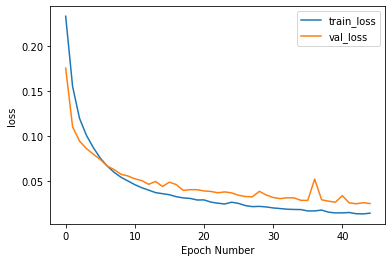

In [11]:
	trainTest.setData()


	trainTest.preprocess(paramsTrain.model_name_id) # move into if

	trainTest.setModel()

	if paramsTrain.train == True:
		trainTest.train()
	else:
		trainTest.modelLoad(paramsTrain.model_name_id)

## Evaluate


In [12]:
trainTest.evaluate()

[@debug] dataset.py:562 in loadMask()
         str(self.paramsTrain.path): '../../../dataset/dataset/cv_data'
[@debug] dataset.py:564 in loadMask()- self.mask.shape: (8492, 7995)
[@debug] dataset.py:386 in addPaddingToInput()
         im.shape: (12, 8492, 7995, 2)
[@debug] params_reconstruct.py:43 in __init__()
         self.overlap: 0
         self.threshold_idx: 4
[@debug] params_reconstruct.py:43 in __init__()
         self.overlap: 0
         self.threshold_idx: 4
[@debug] mosaic.py:45 in __init__()- paramsTrain.seq_date: 'jun'


[@debug] dataset = cv
[@debug] paramsTrain.model_type = UUnetConvLSTM


[@debug] mosaic.py:133 in create()- self.data.class_n: 10
[@debug] mosaic.py:134 in create()
         np.unique(self.data.full_label_test): array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8)
         len(np.unique(self.data.full_label_test)): 10
[@debug] mosaic.py:135 in create()
         np.unique(self.data.full_label_train): array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)
         len(np.unique(self.data.full_label_train)): 10


FileNotFoundError: ignored